In [1]:
import numpy as np 
import pandas as pd
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/mango-leaf-disease-dataset/Powdery Mildew/IMG_20211107_124627 (Custom).jpg
/kaggle/input/mango-leaf-disease-dataset/Powdery Mildew/IMG_20211107_125226 (Custom).jpg
/kaggle/input/mango-leaf-disease-dataset/Powdery Mildew/IMG_20211107_125656 (Custom).jpg
/kaggle/input/mango-leaf-disease-dataset/Powdery Mildew/IMG_20211107_125157 (Custom).jpg
/kaggle/input/mango-leaf-disease-dataset/Powdery Mildew/20211109_121933 (Custom).jpg
/kaggle/input/mango-leaf-disease-dataset/Powdery Mildew/IMG_20211107_125339 (Custom).jpg
/kaggle/input/mango-leaf-disease-dataset/Powdery Mildew/IMG_20211107_115649 (Custom).jpg
/kaggle/input/mango-leaf-disease-dataset/Powdery Mildew/20211109_122151(0) (Custom).jpg
/kaggle/input/mango-leaf-disease-dataset/Powdery Mildew/20211109_122241 (Custom).jpg
/kaggle/input/mango-leaf-disease-dataset/Powdery Mildew/IMG_20211107_130039 (Custom).jpg
/kaggle/input/mango-leaf-disease-dataset/Powdery Mildew/20211109_121859 (Custom).jpg
/kaggle/input/mango-leaf-disease-d

In [2]:
import cv2
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report

In [3]:
# Feature extraction from image
def extract_features(image):
    # Resizing the image
    resized = cv2.resize(image, (100,100)).flatten()
    return resized

In [4]:
# Create empty list for feature matrix and corresponding label
X = []
y = []
disease_class = ['Healthy', 'Anthracnose', 'Bacterial Canker', 'Cutting Weevil', 'Die Back', 'Gall Midge', 'Powdery Mildew', 'Sooty Mould']

# Loading the data
for disease in range(8):
    folder_path = f'/kaggle/input/mango-leaf-disease-dataset/{disease_class[disease]}'
    for filename in os.listdir(folder_path):
        image_path = os.path.join(folder_path, filename)
        image = cv2.imread(image_path)
        features = extract_features(image)
        #Appending features and disease_id to list X and y where X is feature matrix or images and y is corresponding label (disease) for that image
        X.append(features)
        y.append(disease)

In [5]:
# Train test split in 70:30 ratio
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.3,random_state=42)

#Dictionary to map numerical class label to disease class
class_dict = {i: disease_class[i] for i in range(len(disease_class))}

# Creating the decision tree classifier and using it on training dataset
clf = DecisionTreeClassifier()
clf.fit(X_train, y_train)

# Prediction on test dataset
y_pred = clf.predict(X_test)

# Performance evaluation of model
print(classification_report(y_test, y_pred, target_names=disease_class))

                  precision    recall  f1-score   support

         Healthy       0.70      0.63      0.64       167
     Anthracnose       0.64      0.70      0.67       148
Bacterial Canker       0.80      0.77      0.79       158
  Cutting Weevil       0.89      0.87      0.88       149
        Die Back       0.76      0.84      0.80       159
      Gall Midge       0.52      0.56      0.54       135
  Powdery Mildew       0.59      0.63      0.61       134
     Sooty Mould       0.53      0.49      0.51       150

        accuracy                           0.61      1200
       macro avg       0.61      0.61      0.61      1200
    weighted avg       0.60      0.60      0.60      1200



In [6]:
from sklearn.model_selection import GridSearchCV

# Create the parameter grid which is the set of hyperparameters to be tuned
param_grid = {
    'max_depth': [10,13,15,None],                         #We can limit the depth of decision tree to avoid overfitting, but too shallow depth will cause underfitting
    'criterion': ['gini', 'entropy'],              ##There are two criteria of splitting: gini and entropy
    'class_weight': [None, 'balanced'],                 #The default value is None, which means all classes have equal weight. Here, "balanced" causes weight to automatically adjust.
    'min_samples_leaf': [1, 2, 4],       #minimum number of samples required to be at a leaf node. By default it is 1.
    'max_leaf_nodes': [None, 10, 20]     #maximum number of leaf nodes that the decision tree can have. By default it is None, which means no limit on the number of leaf nodes
}

# Create GridSearchCV object to performs an exhaustive search over the hyperparameter space defined in param_grid.
grid_search = GridSearchCV(estimator = clf, param_grid = param_grid, n_jobs=-1)

# Fitting the GridSearchCV object to the training dataset
grid_search.fit(X_train, y_train)

# Print the best parameters found by GridSearchCV
best_params = grid_search.best_params_
print("Best parameters found by GridSearch: ", best_params)

#Now we have the best hyperparameters to create a new Decision Tree Classifier and train it on the training data
#Here **best_params unpacks the best_params dictionary as keyword arguments
improved_clf = DecisionTreeClassifier(**best_params, random_state=42)
improved_clf.fit(X_train, y_train)

# Prediction in test dataset
y_pred = improved_clf.predict(X_test)

# Evaluating the performance of final improved model
print(classification_report(y_test, y_pred, target_names=disease_class))

Best parameters found by GridSearch:  {'class_weight': 'balanced', 'criterion': 'entropy', 'max_depth': 13, 'max_leaf_nodes': None, 'min_samples_leaf': 2}
                  precision    recall  f1-score   support

         Healthy       0.67      0.60      0.64       167
     Anthracnose       0.69      0.64      0.66       148
Bacterial Canker       0.69      0.73      0.71       158
  Cutting Weevil       0.92      0.93      0.92       149
        Die Back       0.79      0.84      0.81       159
      Gall Midge       0.47      0.52      0.49       135
  Powdery Mildew       0.64      0.66      0.65       134
     Sooty Mould       0.50      0.47      0.48       150

        accuracy                           0.68      1200
       macro avg       0.67      0.67      0.67      1200
    weighted avg       0.68      0.68      0.68      1200



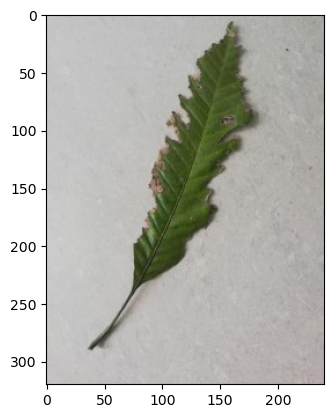

In [7]:
#To check how well our model perform after hyperparameter tuning I'll give a sample image from original dataset and predict the disease class.
import cv2
import matplotlib.pyplot as plt
img = cv2.imread('/kaggle/input/mango-leaf-disease-dataset/Bacterial Canker/IMG_20211106_120700 (Custom).jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)
plt.show()

In [8]:
img_features = extract_features(img)
class_prediction = improved_clf.predict(img_features.reshape(1, -1))[0]
disease_prediction = class_dict[class_prediction]
print(f"The predicted disease for given image is: {disease_prediction}")

The predicted disease for given image is: Bacterial Canker
